In [ ]:
!pip install livelossplot --upgrade --quiet

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import os
import gc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
color = sns.color_palette()
%matplotlib inline
import gzip
import shutil
import re
from PIL import Image as IMG
import cv2
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Input, Dense, Flatten, concatenate, Embedding, LSTM,GRU, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TerminateOnNaN
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.applications import InceptionResNetV2

/kaggle/input/avito-demand-prediction/periods_train.csv
/kaggle/input/avito-demand-prediction/train_jpg_0.zip
/kaggle/input/avito-demand-prediction/sample_submission.csv
/kaggle/input/avito-demand-prediction/train_jpg_3.zip
/kaggle/input/avito-demand-prediction/train_jpg_4.zip
/kaggle/input/avito-demand-prediction/train_active.csv
/kaggle/input/avito-demand-prediction/test_active.csv
/kaggle/input/avito-demand-prediction/train_jpg_2.zip
/kaggle/input/avito-demand-prediction/train_jpg_1.zip
/kaggle/input/avito-demand-prediction/train.csv
/kaggle/input/avito-demand-prediction/test.csv
/kaggle/input/avito-demand-prediction/periods_test.csv
/kaggle/input/avito-demand-prediction/test_jpg.zip
/kaggle/input/avito-demand-prediction/train_jpg.zip


In [ ]:
train_df = pd.read_csv("/kaggle/input/avito-demand-prediction/train.csv", parse_dates=["activation_date"])
test_df = pd.read_csv("/kaggle/input/avito-demand-prediction/test.csv", parse_dates=["activation_date"])
print("Train file rows and columns are : ", train_df.shape)
print("Test file rows and columns are : ", test_df.shape)

In [ ]:
train_df.head()

In [ ]:
column_name = train_df.columns
print('Checking the Number of NaN values per column:')
for col in column_name[:-1]:
    print(f'train {col} has {train_df[col].isnull().sum()} test {col} has {test_df[col].isnull().sum()}')

In [ ]:
# filling the nan value of price with mean value w.r.t its category
train_df['price'] = train_df['price'].fillna(train_df.groupby('category_name')['price'].transform('mean'))
test_df['price'] = test_df['price'].fillna(test_df.groupby('category_name')['price'].transform('mean'))

In [ ]:
train_df['image'] = train_df['image'].fillna(train_df.groupby('parent_category_name')['image'].apply(lambda x: x.fillna(x.mode()[0])))
test_df['image'] =  test_df['image'].fillna(test_df.groupby('parent_category_name')['image'].apply(lambda x: x.fillna(x.mode()[0])))

In [ ]:
# filling NaN values with missing
for col in column_name[:-1]:
    train_df[col] = train_df[col].fillna('missing')
    test_df[col] = test_df[col].fillna('missing')

In [ ]:
train_df = train_df.sample(50000, random_state=42)

In [ ]:
train_df['image'] = 'data/competition_files/train_jpg/'+train_df['image']+'.jpg'

In [ ]:
import zipfile
myzip = zipfile.ZipFile("../input/avito-demand-prediction/train_jpg.zip")
paths = train_df.image.values.tolist()
for file in paths:
    if os.path.exists(file) == False:
        myzip.extract(file, path=file)
myzip.close()

In [ ]:
train_df['image'] = train_df['image'].apply(lambda x: './'+ x +'/' + x)

In [ ]:
# splitting the data with train test split, I am making the test size = 10% only for getting more data to train
X = train_df.drop(['deal_probability'], axis=1)
Y = train_df['deal_probability']
X_train, X_cv, y_train, y_cv = train_test_split(X, Y, test_size=0.10, random_state=42, shuffle=False)

In [ ]:
train_image = pd.DataFrame()
train_image['image'] = X_train['image']
train_image['deal_probability'] = y_train

cv_image = pd.DataFrame()
cv_image['image'] = X_cv['image']
cv_image['deal_probability'] = y_cv

test_image = pd.DataFrame()
test_image['image'] = test_df['image']
test_image['item_id'] = test_df['item_id']

train_image.to_csv('train_image.csv', index=False)
test_image.to_csv('test_image.csv', index=False)
cv_image.to_csv('cv_image.csv', index=False)

In [ ]:
# Feature engineering are inspired by this kernel --> https://www.kaggle.com/vikasmalhotra08/eda-and-lightgbm-for-avito

def feature_engineering(dataset):
    '''This function creates the new feature with aggregating feature with mean, median, sum, min, and max'''
    
    # making aggregates feature with mean, sum and max.
    data = pd.DataFrame()
    data['price'] = dataset['price']
    data["user_price_mean"] = dataset.groupby("user_id")["price"].transform("mean")
    data["user_ad_count"]  = dataset.groupby("user_id")["price"].transform("sum")
    
    data["region_price_mean"]   = dataset.groupby("region")["price"].transform("mean")
    data["region_price_median"] = dataset.groupby("region")["price"].transform("median")
    data["region_price_max"]    = dataset.groupby("region")["price"].transform("max")
    data["region_price_min"]    = dataset.groupby("region")["price"].transform("min")
    
    data["city_price_mean"]   = dataset.groupby("city")["price"].transform("mean")
    data["city_price_median"] = dataset.groupby("city")["price"].transform("median")
    data["city_price_max"]    = dataset.groupby("city")["price"].transform("max")
    data["city_price_min"]    = dataset.groupby("city")["price"].transform("min")
    
    data["parent_category_name_price_mean"]   = dataset.groupby("parent_category_name")["price"].transform("mean")
    data["parent_category_name_price_median"] = dataset.groupby("parent_category_name")["price"].transform("median")
    data["parent_category_name_price_max"]    = dataset.groupby("parent_category_name")["price"].transform("max")
    data["parent_category_name_price_min"]    = dataset.groupby("parent_category_name")["price"].transform("min")
    
    data["category_name_price_mean"]   = dataset.groupby("category_name")["price"].transform("mean")
    data["category_name_price_median"] = dataset.groupby("category_name")["price"].transform("median")
    data["category_name_price_max"]    = dataset.groupby("category_name")["price"].transform("max")
    data["category_name_price_min"]    = dataset.groupby("category_name")["price"].transform("min")
    
    data["region_city_price_mean"]   = dataset.groupby(["region", "city"])["price"].transform("mean")
    data["region_city_price_median"] = dataset.groupby(["region", "city"])["price"].transform("median")
    data["region_city_price_max"]   = dataset.groupby(["region", "city"])["price"].transform("max")
    data["region_city_price_min"]   = dataset.groupby(["region", "city"])["price"].transform("min")
    
    data["user_type_parent_category_price_mean"]   = dataset.groupby(["user_type", "parent_category_name"])["price"].transform("mean")
    data["user_type_parent_category_price_median"] = dataset.groupby(["user_type", "parent_category_name"])["price"].transform("median")
    data["user_type_parent_category_price_max"]   = dataset.groupby(["user_type", "parent_category_name"])["price"].transform("max")
    data["user_type_parent_category_price_min"]   = dataset.groupby(["user_type", "parent_category_name"])["price"].transform("min")
    
    data["user_type_category_price_mean"]   = dataset.groupby(["user_type", "category_name"])["price"].transform("mean")
    data["user_type_category_price_median"] = dataset.groupby(["user_type", "category_name"])["price"].transform("median")
    data["user_type_category_price_max"]   = dataset.groupby(["user_type", "category_name"])["price"].transform("max")
    data["user_type_category_price_min"]   = dataset.groupby(["user_type", "category_name"])["price"].transform("min")
    
    # calling the text_featuring function which extract features from the title and description.
    data["title_words_length"] = dataset["title"].apply(lambda x: len(x.split()))
    data["description_words_length"] = dataset["description"].apply(lambda x: len(x.split()))
    
    data['symbol1_count'] = dataset['description'].str.count('↓')
    data['symbol2_count'] = dataset['description'].str.count('\*')
    data['symbol3_count'] = dataset['description'].str.count('✔')
    data['symbol4_count'] = dataset['description'].str.count('❀')
    data['symbol5_count'] = dataset['description'].str.count('➚')
    data['symbol6_count'] = dataset['description'].str.count('ஜ')
    data['symbol7_count'] = dataset['description'].str.count('.')
    data['symbol8_count'] = dataset['description'].str.count('!')
    data['symbol9_count'] = dataset['description'].str.count('\?')
    data['symbol10_count'] = dataset['description'].str.count('  ')
    data['symbol11_count'] = dataset['description'].str.count('-')
    data['symbol12_count'] = dataset['description'].str.count(',') 
    
    return data

In [ ]:
test = test_df

In [ ]:
num_feature_train = feature_engineering(X_train) # calling function for train set
num_feature_cv = feature_engineering(X_cv)       # calling function for cv set
num_feature_test = feature_engineering(test)     # calling function for test set

In [ ]:
# let standardize our each of the numerical feature
columns = num_feature_train.columns.to_list()
for col in columns:
    scaler = MinMaxScaler()
    num_feature_train[col] = scaler.fit_transform(num_feature_train[col].values.reshape(-1,1))
    num_feature_cv[col] = scaler.transform(num_feature_cv[col].values.reshape(-1,1))
    num_feature_test[col] = scaler.transform(num_feature_test[col].values.reshape(-1,1))

In [ ]:
def categorical_encoder(Train, CV, Test, name):
    '''This function encode the categorical feature which we will use in NN along with embedding layer'''
    tokeniser = Tokenizer(filters='', lower=False, split='뷁', oov_token='oov' )
    tokeniser.fit_on_texts(Train)
    pickle.dump(tokeniser, open(name+'tokeniser.pkl', 'wb'))
    Train = np.array(tokeniser.texts_to_sequences(Train)).astype(np.float64)
    CV = np.array(tokeniser.texts_to_sequences(CV)).astype(np.float64)
    Test = np.array(tokeniser.texts_to_sequences(Test)).astype(np.float64)
    length = len(tokeniser.word_index)+1
    
    return Train, CV, Test, length

In [ ]:
user_type_train, user_type_cv, user_type_test, user_type_length = categorical_encoder(X_train['user_type'], X_cv['user_type'], test['user_type'], 'user_type')

parent_category_train, parent_category_cv, parent_category_test, parent_category_length = categorical_encoder(X_train['parent_category_name'], X_cv['parent_category_name'], test['parent_category_name'], 'parent_category_name')

category_train, category_cv, category_test, category_length = categorical_encoder(X_train['category_name'], X_cv['category_name'], test['category_name'],'category_name')

region_train, region_cv, region_test, region_length = categorical_encoder(X_train['region'],X_cv['region'], test['region'], 'region')

city_train, city_cv, city_test, city_length = categorical_encoder(X_train['city'], X_cv['city'], test['city'],'city')

param_1_train, param_1_cv, param_1_test, param_1_length = categorical_encoder(X_train['param_1'], X_cv['param_1'], test['param_1'], 'param_1')

param_2_train, param_2_cv, param_2_test, param_2_length = categorical_encoder(X_train['param_2'], X_cv['param_2'], test['param_2'], 'param_2')

param_3_train,param_3_cv, param_3_test, param_3_length = categorical_encoder(X_train['param_3'], X_cv['param_3'], test['param_3'], 'param_3')

image_top_train, image_top_cv, image_top_test, image_top_length = categorical_encoder(X_train['image_top_1'].astype(str), X_cv['image_top_1'].astype(str), test['image_top_1'].astype(str), 'image_top_1')

In [ ]:
# downloading the fasttext russian word vectors
!pip install wget
import wget
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ru.vec

In [ ]:
# getting the embedding index from the  russian word vector

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in tqdm(open('./wiki.ru.vec', 'r', encoding='utf-8', newline='\n', errors='ignore')))

In [ ]:
def text_clean(text):
    '''This function clean the russian text'''
    text = str(text)
    text = text.lower()
    clean = re.sub(r"[,.;@#?!&$]+\ *", " ", text)
    return clean

In [ ]:
max_features_title = 150000 # this is the maximum number of feature due to memory constraint
max_length_title = 8        # this is the maximum length of feature due to memory constraint
embed_size_title = 300      # this is the maximum dimension of feature due to memory constraint

train_df['title'] = train_df['title'].apply(text_clean)

title_train = train_df['title'].values

tokenizer_title = Tokenizer(num_words=max_features_title)
tokenizer_title.fit_on_texts(title_train)
pickle.dump(tokenizer_title, open('tokeniser_title.pkl', 'wb'))

word_index = tokenizer_title.word_index
nb_words = min(max_features_title, len(word_index))
embedding_matrix_title = np.zeros((max_features_title, 300))

for word, i in tqdm(word_index.items()):      #generating the embedding matrix for title
    if i <= max_features_title:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix_title[i] = embedding_vector
        

pickle.dump(embedding_matrix_title, open("embedding_matrix_title.pkl", "wb"))

In [ ]:
max_features_desc = 300000           # this is the maximum number of feature due to memory constraint
max_length_desc = 200                # this is the maximum length of feature due to memory constraint
embed_size_desc = 300                # this is the maximum dimension of feature due to memory constraint

train_df['description'] = train_df['description'].apply(text_clean)


description_train = train_df['description'].values

tokenizer_desc = Tokenizer(num_words=max_features_desc)
tokenizer_desc.fit_on_texts(description_train)
pickle.dump(tokenizer_desc, open('tokeniser_desc.pkl', 'wb'))

word_index = tokenizer_desc.word_index
nb_words = min(max_features_desc, len(word_index))
embedding_matrix_desc = np.zeros((nb_words, embed_size_desc))

for word, i in tqdm(word_index.items()):       #generating the embedding matrix for description
    if i <= max_features_desc:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix_desc[i] = embedding_vector
            
pickle.dump(embedding_matrix_desc, open("embedding_matrix_desc.pkl", "wb"))

In [ ]:
import os
os.remove('./wiki.ru.vec')

In [ ]:
y_cv.to_csv('./y_cv.csv', index=False)
y_train.to_csv("./y_train.csv", index=False)

In [ ]:
import gc
del train_final
del cv_final
gc.collect()

In [ ]:
def encoder(train, cv, test, tokenizer, max_length):

  ''' This function perform the tokenization and then convert words to integers and then perform padding and returns the values '''
    # integer encode
  encoded_train = tokenizer.texts_to_sequences(train)
  encoded_cv = tokenizer.texts_to_sequences(cv)
  encoded_test = tokenizer.texts_to_sequences(test)

  padded_train = np.array(pad_sequences(encoded_train, maxlen=max_length, padding='post')).astype(np.float64)
  padded_cv = np.array(pad_sequences(encoded_cv, maxlen=max_length, padding='post')).astype(np.float64)
  padded_test = np.array(pad_sequences(encoded_test, maxlen=max_length, padding='post')).astype(np.float64)


  return padded_train, padded_cv, padded_test

padded_title_train, padded_title_cv, padded_title_test = encoder(X_train['title'], X_cv['title'], test['title'], tokenizer_title, max_length_title)

padded_desc_train, padded_desc_cv, padded_desc_test = encoder(X_train['description'], X_cv['description'], test['description'], tokenizer_desc, max_length_desc)

In [ ]:
tr = [], cv = []

for i in tqdm(train_image['image']):
    full_size_image = cv2.imread(i)
    tr.append(cv2.resize(full_size_image, (128,128), interpolation=cv2.INTER_NEAREST))
tr = np.asarray(tr)

for i in tqdm(cv_image['image']):
    full_size_image = cv2.imread(i)
    cv.append(cv2.resize(full_size_image, (128,128), interpolation=cv2.INTER_CUBIC))
cv = np.asarray(cv)

pickle.dump(tr, open('train_image_array.pkl', 'wb'), protocol=4)
pickle.dump(cv, open('cv_image_array.pkl', 'wb'))

In [ ]:
# gtting all the inputs into a list
train_final = [padded_title_train, padded_desc_train, user_type_train,parent_category_train,category_train,region_train,city_train,\
               param_1_train, param_2_train, param_3_train,image_top_train, num_feature_train.to_numpy().astype(np.float64)]

cv_final = [padded_title_cv, padded_desc_cv, user_type_cv, parent_category_cv,category_cv,region_cv,city_cv,
               param_1_cv, param_2_cv, param_3_cv, image_top_cv, num_feature_cv.to_numpy().astype(np.float64)]

test_final = [padded_title_test, padded_desc_test, user_type_test,parent_category_test,category_test,region_test,city_test,
               param_1_test, param_2_test, param_3_test, image_top_test, num_feature_test.to_numpy().astype(np.float64)]

In [ ]:
pickle.dump(train_final, open("train_final.pkl", "wb"), protocol=4)
pickle.dump(cv_final, open("cv_final.pkl", "wb"), protocol=4)
pickle.dump(test_final, open("test_final.pkl", "wb"), protocol=4)

In [ ]:
train_image_array = pickle.load(open('train_image_array.pkl', 'rb'))
cv_image_array = pickle.load(open('cv_image_array.pkl', 'rb'))

In [3]:
embedding_matrix_title = pickle.load(open('./embedding_matrix_title.pkl', 'rb'))
embedding_matrix_desc = pickle.load(open('./embedding_matrix_desc.pkl', 'rb'))

In [4]:
embedding_matrix_title = embedding_matrix_title[0:,0:100]
embedding_matrix_desc = embedding_matrix_desc[0:,0:100]

In [5]:
train_final = pickle.load(open('train_final.pkl', 'rb'))
cv_final = pickle.load(open('cv_final.pkl', 'rb'))
#test_final = pickle.load(open('test_final.pkl', 'rb'))

In [ ]:
train_image = pd.read_csv('./train_image.csv')
cv_image = pd.read_csv('./cv_image.csv')

In [ ]:
test_final = pickle.load(open('test_final.pkl', 'rb'))

In [6]:
y_train = pd.read_csv('y_train.csv')
y_cv = pd.read_csv('y_cv.csv')

In [7]:
max_features_desc = 300000
max_length_desc = 200
embed_size_desc = 100
max_features_title = 150000
max_length_title = 8
embed_size_title = 100


user_type_length = 5
parent_category_length = 11
category_length = 49 
region_length = 30
city_length = 1728
param_1_length = 372
param_2_length = 270
param_3_length = 1202
image_top_length = 3064

In [8]:
import keras.backend as K
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [9]:
def dense_layer(X, units, drop):
    X = Dense(units, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.001))(X)
    X = BatchNormalization()(X)
    X = Dropout(drop)(X)
    return X

In [15]:
def Transfer_Learning_Inception(input_shape, fine_tune=0):
    """
    Compiles a model integrated with Inception pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = InceptionResNetV2(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
#     conv_layer = Conv2D(filters=64,kernel_size=(2,2),strides=(1,1),padding='same',activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(), kernel_regularizer=l2(0.001))(top_model)
#     Pool = MaxPooling2D(pool_size=(2,2),strides=(1,1),padding='same')(conv_layer)
    flatten = Flatten()(top_model)
    output_layer = dense_layer(flatten, 128, 0.2)
    #output_layer = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.glorot_normal(), kernel_regularizer=l2(0.001))(flatten)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
    
    return model

In [16]:
def create_NN(length_title, length_desc, vocab_size_title, vocab_size_desc, embedded_matrix_title, embedded_matrix_desc):
    
  embedded_title = Embedding(vocab_size_title, 100, weights=[embedded_matrix_title], trainable= False)
  input_0 = Input(shape= (length_title,), name='title')
  emd_title = embedded_title(input_0)                  #Input of the title feature with embedding matrix

  lstm_0 = GRU(32, activation='relu', return_sequences=True, recurrent_dropout=0.3, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.001))(emd_title)
  flatten_0 = Flatten()(lstm_0)    #LSTM layer for title feature
  
  embedded_desc = Embedding(vocab_size_desc, 100, weights=[embedded_matrix_desc], trainable= False)
  input_1 = Input(shape= (length_desc,), name='description')
  emd_desc = embedded_desc(input_1)                   #Inputs of the description feature with embedding matrix

  lstm_1 = GRU(64, activation='relu', return_sequences=True, recurrent_dropout=0.3, kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.001))(emd_desc)
  flatten_1 = Flatten()(lstm_1)      #LSTM layer for decription feature
  
  input_2 = Input(shape=(1,), name='user_type')             
  emd_user_type = Embedding(user_type_length, 10) (input_2)  #Embedding layer for User_Type categorical feature
  flatten_2 = Flatten()(emd_user_type)
  
  input_3 = Input(shape=(1,), name='parent_category_name')
  emd_parent_cat = Embedding(parent_category_length, 10) (input_3)  #Embedding layer for Parent_Category_name categorical feature
  flatten_3 = Flatten()(emd_parent_cat)
  
  input_4 = Input(shape=(1,), name='category_name')
  emd_category = Embedding(category_length, 10) (input_4)           #Embedding layer for Category_name categorical feature
  flatten_4 = Flatten()(emd_category)
  
  input_5 = Input(shape=(1,), name='region')
  emd_region = Embedding(region_length, 10) (input_5)              #Embedding layer for region categorical feature
  flatten_5 = Flatten()(emd_region)
  
  input_6 = Input(shape=(1,), name='city')
  emd_city = Embedding(city_length, 10) (input_6)                  #Embedding layer for city categorical feature
  flatten_6 = Flatten()(emd_city)

  input_7 = Input(shape=(1,), name='param_1')
  emd_param_1 = Embedding(param_1_length, 10) (input_7)            #Embedding layer for param_1 categorical feature
  flatten_7 = Flatten()(emd_param_1)

  input_8 = Input(shape=(1,), name='param_2')
  emd_param_2 = Embedding(param_2_length, 10) (input_8)           #Embedding layer for param_2 categorical feature
  flatten_8 = Flatten()(emd_param_2)
  
  input_9 = Input(shape=(1,), name='param_3')
  emd_param_3 = Embedding(param_3_length, 10) (input_9)            #Embedding layer for param_3 categorical feature
  flatten_9 = Flatten()(emd_param_3)
  
  input_10 = Input(shape=(1,), name='image_top_1')
  emd_image_top = Embedding(image_top_length, 10) (input_10)        #Embedding layer for image_top_1 categorical feature
  flatten_10 = Flatten()(emd_image_top)
  #concat_cat = concatenate([flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,flatten_7,flatten_8,flatten_9,flatten_10])
  #dense_cat = dense_layer(concat_cat, 64, 0.2 )
  
  input_11 = Input(shape=(45,), name='Engg_features')               #inputs of the numerical feature engg
  dense_0 = Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.001)) (input_11)
  concat = concatenate([flatten_0,flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,flatten_7,flatten_8,flatten_9,flatten_10, dense_0], name='concat_ALL')

  dense_1 = dense_layer(concat, 512, 0.4)
  output_layer = dense_layer(dense_1, 256, 0.4) 
  model = Model(inputs = [input_0,input_1,input_2,input_3,input_4,input_5,input_6,input_7,input_8,input_9,input_10,input_11], outputs=output_layer)

  return model

In [17]:
tf.keras.backend.clear_session()
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
checkpoint = ModelCheckpoint(filepath='final_model_50K.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001,
                           patience=5, 
                           restore_best_weights=True,
                           mode='auto')
#reduce Learning Rate
reduceLR = ReduceLROnPlateau(monitor='val_root_mean_squared_error', min_lr=0.0000001,patience=2, factor=0.5, mode='auto')

#terminate on NaN
terminate = TerminateOnNaN()

tensorboard = tf.keras.callbacks.TensorBoard(log_dir = "logs/fit" , histogram_freq = 1)

input_shape = (128, 128, 3)

NN = create_NN(max_length_title, max_length_desc, max_features_title, max_features_desc, embedding_matrix_title, embedding_matrix_desc)
TL_image = Transfer_Learning_Inception(input_shape)

combined = concatenate([NN.output, TL_image.output])

dense_3 = dense_layer(combined, 128, 0.4)
dense_4 = dense_layer(dense_3, 64, 0.4)

output_layer = Dense(1, activation='linear', kernel_initializer=tf.keras.initializers.HeNormal(), kernel_regularizer=l2(0.001))(dense_4)

model = Model(inputs=[NN.input, TL_image.input], outputs=output_layer)
tf.keras.utils.plot_model(model, show_shapes=True, to_file='base_model_multichannel.png')
optim = Adam(learning_rate=0.001)
model.compile(loss=RMSE, optimizer=optim, metrics= [tf.keras.metrics.RootMeanSquaredError()])

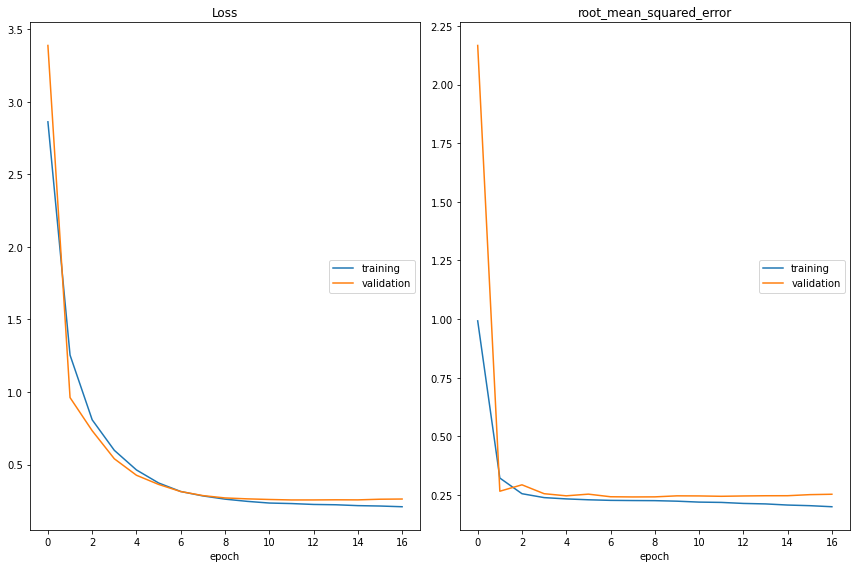

Loss
	training         	 (min:    0.209, max:    2.862, cur:    0.209)
	validation       	 (min:    0.256, max:    3.388, cur:    0.262)
root_mean_squared_error
	training         	 (min:    0.200, max:    0.992, cur:    0.200)
	validation       	 (min:    0.242, max:    2.167, cur:    0.253)


In [18]:
%time
tf.keras.backend.clear_session()
history = model.fit(x = [train_final, train_image_array], y=y_train, validation_data=([cv_final, cv_image_array], y_cv), epochs=20, verbose=2, batch_size=128, callbacks = [checkpoint, early_stop, plot_loss, reduceLR, tensorboard, terminate])

<a href="./final_model_50K.weights.best.hdf5"> Download File </a>
